In [ ]:
# Importing all necessary libraries and frameworks
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import csv
import itertools
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Importing and loading CIFAR10 Dataset

In [ ]:
# Defining training and validation set loaders
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # Define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # Loading the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# Defining testing set loaders
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset
train_loader, val_loader = get_train_valid_loader(data_dir = './data', batch_size = 64,
                       augment = False, random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

100%|██████████| 170498071/170498071 [00:03<00:00, 47133485.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Teacher Network (AlexNet) - 222 MB

In [ ]:
# Defining the teacher network (AlexNet)

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0), # output - 96x55x55
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 96x27x27
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # output - 256x27x27
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 256x13x13
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), # output - 384x13x13
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), # output - 256x13x13
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 256x6x6
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
# Model training parameters
num_classes = 10
epochs = 20
batch_size = 64
learning_rate = 0.005

teacher = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(teacher.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
# Load pretrained model if it is available
if os.path.exists('alexnet_pretrain.pth'):
    teacher = AlexNet(num_classes).to(device)
    teacher.load_state_dict(torch.load('alexnet_pretrain.pth'))
else:
    for i in range(epochs):
      running_loss = 0.0
      correct = 0
      total = 0
      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = teacher(inputs)
        loss = criterion(predictions, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

      # Finding out training loss
      train_loss = running_loss/len(train_loader)
      # training_loss.append(train_loss)

      print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

      # Finding out validation loss and accuracy
      running_loss = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = teacher(inputs)
              loss = criterion(outputs, labels)
              running_loss += loss.item()

              predictions = F.softmax(outputs, dim = 1)
              _, predicted = torch.max(predictions.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      val_loss = running_loss/len(val_loader)
      # validation_loss.append(val_loss)
      print(f'Validation Accuracy: {100 * correct // total} %')
      print()

    # Saving the teacher model
    torch.save(teacher.state_dict(), 'alexnet_pretrain.pth')

Epoch [1 / 20] | Train Loss: 1.397 | Validation Accuracy: 59 %

Epoch [2 / 20] | Train Loss: 0.984 | Validation Accuracy: 69 %

Epoch [3 / 20] | Train Loss: 0.822 | Validation Accuracy: 72 %

Epoch [4 / 20] | Train Loss: 0.725 | Validation Accuracy: 76 %

Epoch [5 / 20] | Train Loss: 0.653 | Validation Accuracy: 76 %

Epoch [6 / 20] | Train Loss: 0.602 | Validation Accuracy: 77 %

Epoch [7 / 20] | Train Loss: 0.562 | Validation Accuracy: 79 %

Epoch [8 / 20] | Train Loss: 0.517 | Validation Accuracy: 78 %

Epoch [9 / 20] | Train Loss: 0.488 | Validation Accuracy: 81 %

Epoch [10 / 20] | Train Loss: 0.453 | Validation Accuracy: 81 %

Epoch [11 / 20] | Train Loss: 0.435 | Validation Accuracy: 80 %

Epoch [12 / 20] | Train Loss: 0.410 | Validation Accuracy: 81 %

Epoch [13 / 20] | Train Loss: 0.396 | Validation Accuracy: 81 %

Epoch [14 / 20] | Train Loss: 0.374 | Validation Accuracy: 82 %

Epoch [15 / 20] | Train Loss: 0.368 | Validation Accuracy: 81 %

Epoch [16 / 20] | Train Loss: 0.35

In [ ]:
# Finding out accuracy of the model on train, val and test data
def evaluate(model, train_loader, val_loader, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            predictions = F.softmax(predictions, dim = 1)
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_acc = 100 * correct // total
    print(f'The training set accuracy is : {train_acc} %')

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            predictions = F.softmax(predictions, dim = 1)
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct // total
    print(f'The validation set accuracy is : {val_acc} %')

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            predictions = F.softmax(predictions, dim = 1)
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct // total
    print(f'The testing set accuracy is : {test_acc} %')

    return train_acc, val_acc, test_acc


train_acc, val_acc, test_acc = evaluate(teacher, train_loader, val_loader, test_loader)

The training set accuracy is : 90 %
The validation set accuracy is : 81 %
The testing set accuracy is : 81 %


In [ ]:
# Finding out number of trainable parameters in the model architecture
def find_num_params(model):
    total_params = sum(
      param.numel() for param in model.parameters()
    )

    print("The number of trainable parameters is -", total_params)


# Finding out size of the model
def find_size_model(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))


find_num_params(teacher)
find_size_model(teacher)

The number of trainable parameters is - 58325066
model size: 222.503MB


# Student Network - 2.8 MB

In [ ]:
# Defining the student network architecture

class Student(nn.Module):
    def __init__(self, num_classes=10):
        super(Student, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=11, stride=4, padding=0), # output - 16x55x55
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 16x27x27
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2), # output - 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) # output - 32x6x6

        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1152, 512),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(256, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Student1

In [ ]:
student1 = Student()
student1 = student1.to(device)

print(student1)

Student(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=512, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# Finding number of parameters and size of the model
find_num_params(student1)
find_size_model(student1)

The number of trainable parameters is - 742986
model size: 2.835MB


In [ ]:
# Defining the training parameters
num_classes = 10
epochs = 10
batch_size = 64
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student1.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
# Student1 - learns entirely from the training data, no contribution of teacher network

alpha = 1.0

training_loss_1 = []
validation_loss_1 = []

for i in range(epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    hard_predictions = F.softmax(student1(inputs), dim=1)
    student_loss = criterion(hard_predictions, labels)

    soft_labels = F.softmax(teacher(inputs), dim=1)
    soft_predictions = student1(inputs)
    distillation_loss = criterion(soft_predictions, soft_labels)

    loss = alpha*student_loss + (1-alpha)*distillation_loss

    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()

    optimizer.step()

  # Finding out training loss
  train_loss = running_loss/len(train_loader)
  training_loss_1.append(train_loss)

  print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

  # Finding out validation loss and accuracy
  running_loss = 0.0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = student1(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          predictions = F.softmax(outputs, dim = 1)
          _, predicted = torch.max(predictions.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_loss = running_loss/len(val_loader)
  validation_loss_1.append(val_loss)
  print(f'Validation Accuracy: {100 * correct // total} %')
  print()

Epoch [1 / 10] | Train Loss: 2.241 | Validation Accuracy: 30 %

Epoch [2 / 10] | Train Loss: 2.105 | Validation Accuracy: 39 %

Epoch [3 / 10] | Train Loss: 2.047 | Validation Accuracy: 44 %

Epoch [4 / 10] | Train Loss: 2.012 | Validation Accuracy: 45 %

Epoch [5 / 10] | Train Loss: 1.991 | Validation Accuracy: 49 %

Epoch [6 / 10] | Train Loss: 1.974 | Validation Accuracy: 49 %

Epoch [7 / 10] | Train Loss: 1.965 | Validation Accuracy: 53 %

Epoch [8 / 10] | Train Loss: 1.955 | Validation Accuracy: 49 %

Epoch [9 / 10] | Train Loss: 1.946 | Validation Accuracy: 52 %

Epoch [10 / 10] | Train Loss: 1.942 | Validation Accuracy: 52 %



In [ ]:
# Evaluating the model's performance on the dataset
train_acc_1, val_acc_1, test_acc_1 = evaluate(student1, train_loader, val_loader, test_loader)

The training set accuracy is : 52 %
The validation set accuracy is : 51 %
The testing set accuracy is : 51 %


# Student2

In [ ]:
student2 = Student()
student2 = student2.to(device)

print(student2)

Student(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=512, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# Defining the training parameters
num_classes = 10
epochs = 10
batch_size = 64
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student2.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
# Student2 - learns entirely from the teacher network, no contribution of training data

alpha = 0.0

training_loss_2 = []
validation_loss_2 = []

for i in range(epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    hard_predictions = F.softmax(student2(inputs), dim=1)
    student_loss = criterion(hard_predictions, labels)

    soft_labels = F.softmax(teacher(inputs), dim=1)
    soft_predictions = student2(inputs)
    distillation_loss = criterion(soft_predictions, soft_labels)

    loss = alpha*student_loss + (1-alpha)*distillation_loss

    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()

    optimizer.step()

  # Finding out training loss
  train_loss = running_loss/len(train_loader)
  training_loss_2.append(train_loss)

  print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

  # Finding out validation loss and accuracy
  running_loss = 0.0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = student2(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          predictions = F.softmax(outputs, dim = 1)
          _, predicted = torch.max(predictions.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_loss = running_loss/len(val_loader)
  validation_loss_2.append(val_loss)
  print(f'Validation Accuracy: {100 * correct // total} %')
  print()

Epoch [1 / 10] | Train Loss: 1.676 | Validation Accuracy: 44 %

Epoch [2 / 10] | Train Loss: 1.398 | Validation Accuracy: 52 %

Epoch [3 / 10] | Train Loss: 1.288 | Validation Accuracy: 56 %

Epoch [4 / 10] | Train Loss: 1.223 | Validation Accuracy: 57 %

Epoch [5 / 10] | Train Loss: 1.183 | Validation Accuracy: 58 %

Epoch [6 / 10] | Train Loss: 1.152 | Validation Accuracy: 61 %

Epoch [7 / 10] | Train Loss: 1.128 | Validation Accuracy: 61 %

Epoch [8 / 10] | Train Loss: 1.107 | Validation Accuracy: 62 %

Epoch [9 / 10] | Train Loss: 1.091 | Validation Accuracy: 62 %

Epoch [10 / 10] | Train Loss: 1.076 | Validation Accuracy: 64 %



In [ ]:
# Evaluating the model's performance on the dataset
train_acc_2, val_acc_2, test_acc_2 = evaluate(student2, train_loader, val_loader, test_loader)

The training set accuracy is : 64 %
The validation set accuracy is : 63 %
The testing set accuracy is : 63 %


# Student3

In [ ]:
student3 = Student()
student3 = student3.to(device)

print(student3)

Student(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1152, out_features=512, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
# Defining the training parameters
num_classes = 10
epochs = 10
batch_size = 64
learning_rate = 0.005

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(student3.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [ ]:
# Student3 - learns from both the teacher network as well as training data equally

alpha = 0.5

training_loss_3 = []
validation_loss_3 = []

for i in range(epochs):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    hard_predictions = F.softmax(student3(inputs), dim=1)
    student_loss = criterion(hard_predictions, labels)

    soft_labels = F.softmax(teacher(inputs), dim=1)
    soft_predictions = student3(inputs)
    distillation_loss = criterion(soft_predictions, soft_labels)

    loss = alpha*student_loss + (1-alpha)*distillation_loss

    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()

    optimizer.step()

  # Finding out training loss
  train_loss = running_loss/len(train_loader)
  training_loss_3.append(train_loss)

  print('Epoch [%d / %d] | Train Loss: %.3f |'%((i+1), epochs, train_loss), end=' ')

  # Finding out validation loss and accuracy
  running_loss = 0.0
  with torch.no_grad():
      for inputs, labels in val_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = student3(inputs)
          loss = criterion(outputs, labels)
          running_loss += loss.item()

          predictions = F.softmax(outputs, dim = 1)
          _, predicted = torch.max(predictions.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_loss = running_loss/len(val_loader)
  validation_loss_3.append(val_loss)
  print(f'Validation Accuracy: {100 * correct // total} %')
  print()

Epoch [1 / 10] | Train Loss: 1.964 | Validation Accuracy: 44 %

Epoch [2 / 10] | Train Loss: 1.746 | Validation Accuracy: 52 %

Epoch [3 / 10] | Train Loss: 1.661 | Validation Accuracy: 54 %

Epoch [4 / 10] | Train Loss: 1.613 | Validation Accuracy: 57 %

Epoch [5 / 10] | Train Loss: 1.581 | Validation Accuracy: 59 %

Epoch [6 / 10] | Train Loss: 1.559 | Validation Accuracy: 60 %

Epoch [7 / 10] | Train Loss: 1.542 | Validation Accuracy: 61 %

Epoch [8 / 10] | Train Loss: 1.531 | Validation Accuracy: 61 %

Epoch [9 / 10] | Train Loss: 1.520 | Validation Accuracy: 62 %

Epoch [10 / 10] | Train Loss: 1.508 | Validation Accuracy: 64 %



In [ ]:
# Evaluating the model's performance on the dataset
train_acc_3, val_acc_3, test_acc_3 = evaluate(student3, train_loader, val_loader, test_loader)

The training set accuracy is : 64 %
The validation set accuracy is : 63 %
The testing set accuracy is : 63 %


# Comparison of Student Networks

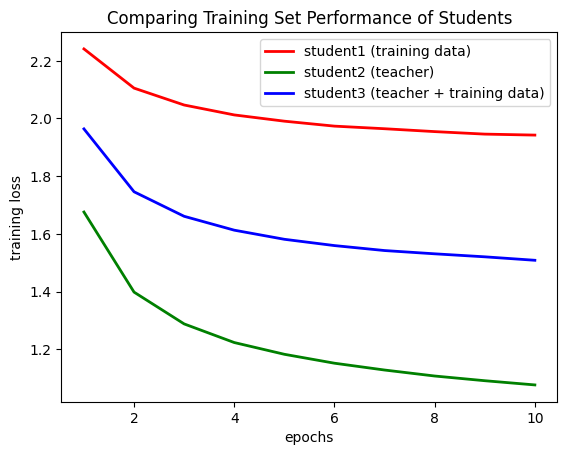

In [ ]:
# Comparing the performance of the three students on training data

plt.figure()
plt.plot([(i+1) for i in range(epochs)], training_loss_1, 'r', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], training_loss_2, 'g', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], training_loss_3, 'b', linewidth=2)
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend(['student1 (training data)', 'student2 (teacher)', 'student3 (teacher + training data)'])
plt.title('Comparing Training Set Performance of Students')
plt.show()

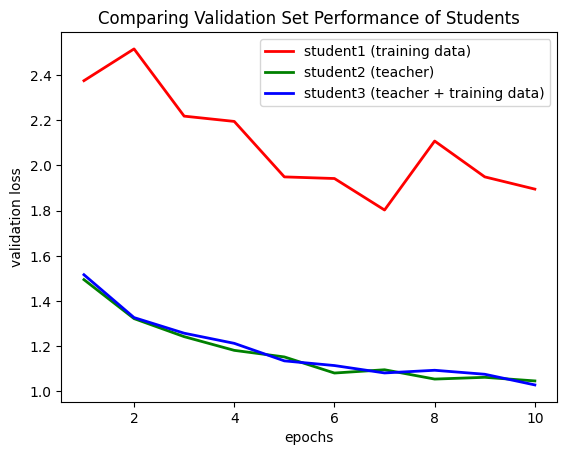

In [ ]:
# Comparing the performance of the three students on validation data

plt.figure()
plt.plot([(i+1) for i in range(epochs)], validation_loss_1, 'r', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], validation_loss_2, 'g', linewidth=2)
plt.plot([(i+1) for i in range(epochs)], validation_loss_3, 'b', linewidth=2)
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.legend(['student1 (training data)', 'student2 (teacher)', 'student3 (teacher + training data)'])
plt.title('Comparing Validation Set Performance of Students')
plt.show()

In [ ]:
# Comparative evaluation of the student networks' performance against the teacher network
data = {
   'Teacher': [train_acc, val_acc, test_acc],
   'Student1': [train_acc_1, val_acc_1, test_acc_1],
   'Student2': [train_acc_2, val_acc_2, test_acc_2],
   'Student3': [train_acc_3, val_acc_3, test_acc_3],
}

labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
bar_width = 0.2

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

for i, (group, values) in enumerate(data.items()):
   pos = x_pos + (i * bar_width)
   ax.bar(pos, values, width=bar_width, label=group)

ax.set_xticks(x_pos + ((len(data) - 1) / 2) * bar_width)
ax.set_xticklabels(labels)

ax.legend()

ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparing Teacher and Student Networks')

plt.show()


Observations -

*   The 3 student networks show significantly worse performance than the teacher AlexNet network, which is to be expected given the difference in their complexities.
*   Each student network has 743k parameters, and is of size 2.8 MB, as compared to the teacher network, which has 59M parameters and is of size 222 MB, significantly higher than the student networks.
* Student2 (trained from only the teacher network) and Student3 (trained from both the teacher network as well as the training dataset) give identical accuracies on the training, validation and testing datasets, while Student1 (trained from only the training dataset) gives much lower accuracies.

Conclusion -
* We can conclude that when a much lighter and less complex student network needs to be used for predictive analysis on a large dataset and can only be trained for a low number of epochs, it is best to train it using knowledge distillation from a much more complex teacher network, which has already been pre-trained on the said dataset. The student network will return better performances if it learns to mimic the teacher network's predictions, rather than trying to learn from the large, complex dataset itself.

Further Work -
* We can experiment with and compare the student networks' performance by only allowing them to utilise a small portion of the entire dataset during the training process.

